<a href="https://colab.research.google.com/github/Roi-Mash/Fake-news-detection/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
# Computations
import itertools

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import (LSTM,Embedding, Dense, Bidirectional, Dropout)
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
train = pd.read_csv("https://raw.githubusercontent.com/FakeNewsDetection/FakeBuster/master/datasets/train.csv")
train.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [2]:

train.isnull().sum()

train['total']=train['title']+' '+train['author']+' '+train['text']
###Drop Nan Values
train=train.dropna()

## Get the Independent Features
X=train.drop('label',axis=1)

## Get the Dependent features
y=train['label']

In [3]:
train.head()

,id,title,author,text,label,total
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [4]:
y.value_counts()

0    10361
1     7924
Name: label, dtype: int64

In [5]:

### Vocabulary size
voc_size=5000

In [6]:
messages=X.copy()
messages.reset_index(inplace=True)
messages['total'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart Daniel J. Flynn Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates

In [ ]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    if i%100==0:
      print(i)
    review = re.sub('[^a-zA-Z]', ' ', messages['total'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000


In [ ]:
# Creating a function that outputs a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def precision_recall(true_label, predicted_label):
    precision = precision_score(true_label, predicted_label)
    print('Precision: %f' % precision)

    recall = recall_score(true_label, predicted_label)
    print('Recall: %f' % recall)
    
    accuracy = metrics.accuracy_score(true_label, predicted_label)
    print('Accuracy: %f' % accuracy)

In [ ]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [ ]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[1565 3296 4691 ... 3954 4478 2860]
 [2446 3085 4062 ... 1279 1471 1094]
 [3651  849 2450 ... 3878  174 4416]
 ...
 [1902  609 1108 ... 2766 3603 2853]
 [4302  368 1016 ... 4227 2161 1535]
 [2785 2014 1881 ... 3654 2004  591]]


In [ ]:
## Creating LSTM model
embedding_vector_features=40
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length = sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer = 'adam',loss ='binary_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
dropout_18 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

In [ ]:
### Finally Training
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)


Epoch 1/10
229/229 [==============================] - 10s 34ms/step - loss: 0.5342 - accuracy: 0.6936 - val_loss: 0.3179 - val_accuracy: 0.8589
Epoch 2/10
229/229 [==============================] - 7s 32ms/step - loss: 0.2564 - accuracy: 0.8935 - val_loss: 0.3175 - val_accuracy: 0.8619
Epoch 3/10
229/229 [==============================] - 7s 32ms/step - loss: 0.2041 - accuracy: 0.9181 - val_loss: 0.3348 - val_accuracy: 0.8564
Epoch 4/10
229/229 [==============================] - 9s 39ms/step - loss: 0.1601 - accuracy: 0.9410 - val_loss: 0.3706 - val_accuracy: 0.8586
Epoch 5/10
229/229 [==============================] - 7s 32ms/step - loss: 0.1277 - accuracy: 0.9546 - val_loss: 0.4535 - val_accuracy: 0.8491
Epoch 6/10
229/229 [==============================] - 7s 32ms/step - loss: 0.0942 - accuracy: 0.9664 - val_loss: 0.4814 - val_accuracy: 0.8400
Epoch 7/10
229/229 [==============================] - 8s 36ms/step - loss: 0.0783 - accuracy: 0.9727 - val_loss: 0.5711 - val_accuracy: 0.840

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Precision: 0.830709
Recall: 0.803810
Accuracy: 0.844955


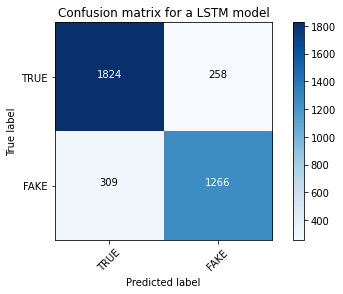

In [ ]:
# pred_LSTM = model.predict(X_test)
pred_LSTM = model.predict_classes(X_test)
precision_recall(y_test, pred_LSTM)

cm2 = metrics.confusion_matrix(y_test, pred_LSTM, labels=[0,1])
plot_confusion_matrix(cm2, classes=['TRUE','FAKE'], title ='Confusion matrix for a LSTM model')